# Elections - Notebook

In [7]:
import time

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from pabutools.election import (
    parse_pabulib,
    Cost_Sat,
    Cost_Sqrt_Sat,
    Effort_Sat,
    Cardinality_Sat,
)
from pabutools.rules import greedy_utilitarian_welfare, method_of_equal_shares
# from visualize import visualize_data

## Functionalities:

In [3]:
def print_outcome(outcome, name, instance):
    """
    Print the outcome of the algorithm.
    """
    print("Outcome of " + name + ":")
    cost = 0
    for projects in outcome:
        # print("Name: " + str(projects.name) + ", Cost: " + str(projects.cost))
        cost += projects.cost

    print(
        "Total cost: "
        + str(cost)
        + ". Budget left: "
        + str(instance.budget_limit - cost)
    )


def print_profile_info(instance, profile):
    """
    Print the information about the profile.
    """
    print(
        "Minimum Length of Ballots: " + str(profile.legal_min_length)
    )  # Imposed minimum length of the ballots in the profile
    print(
        "Maximum Length of Ballots: " + str(profile.legal_max_length)
    )  # Imposed maximum length of the ballots in the profile

    print(
        "Minimum Total Cost of Ballots: " + str(profile.legal_min_cost)
    )  # Imposed minimum total cost of the ballots in the profile
    print(
        "Maximum Total Cost of Ballots: " + str(profile.legal_max_cost)
    )  # Imposed maximum total cost of the ballots in the profile

    print("Budget limit is: " + str(instance.budget_limit))

    return


def perform_election(path, algorithm, algorithm_name, sat_class):

    instance, profile = parse_pabulib(path)
    # print_profile_info(instance, profile)

    start = time.time()
    outcome = algorithm(instance, profile, sat_class=sat_class)
    end = time.time()

    print_outcome(outcome, algorithm_name, instance)
    print(f"Time taken {algorithm_name}: {end - start:.2f} seconds")

    return outcome


def get_shares(outcome, profile, instance):
    """
    Shares based on Definition (and Example) 1 from the paper.
    Fair shares based on Definition 2 from the paper.
    """
    shares = []
    fair_shares = []

    # Dict for projects + their costs
    selected_projects = {project.name: float(project.cost) for project in outcome}

    # Dict for projects + their voters
    total_voters_per_project = {
        project.name: sum(project.name in ballot for ballot in profile)
        for project in outcome
    }

    # Get shares and fair shares for each voter
    for ballot in profile:
        agent_share = sum(
            selected_projects[project] / total_voters_per_project[project]
            for project in ballot
            if project in selected_projects
        )
        shares.append(agent_share)
        b_over_n = float(instance.budget_limit) / len(profile)
        fair_shares.append(min(b_over_n, agent_share))

    return shares, fair_shares


def get_average_capped_fair_share_ratio(shares, fair_shares):
    """
    Average capped fair share ratio based on page 17 from the paper.
    """
    # TODO: take into account the case where the denominator is 0

    num_agents = len(shares)
    sum_fair_shares = 0
    for i in range(num_agents):
        if shares[i] == 0:
            sum_fair_shares += 1
        else:
            sum_fair_shares += min(1, fair_shares[i] / shares[i])

    return sum_fair_shares / num_agents


def get_average_l1_distance(shares, fair_shares):
    """
    Average L1 distance also based on page 17 from the paper.
    """
    num_agents = len(shares)
    return sum(abs(shares[i] - fair_shares[i]) for i in range(num_agents)) / num_agents

## Some intialization

In [4]:
# Bins of no. of projects: 2 - 7, 8 - 13, 14 - 19 20 - 30, 31 - 6
bins = {
    "2 - 7": {},
    "8 - 13": {},
    "14 - 19": {},
    "20 - 30": {},
    "31 - 65": {},
}
outcomes = {
    "Greedy": {},
    "MES Cost_Sat": {},
    "MES Cost_Sqrt_Sat": {},
    "MES Effort_Sat": {},
    "MES Cardinality_Sat": {},
}

for measure in outcomes:
    outcomes[measure] = {
        "projects": [],
        "avg_capped": [],
        "avg_l1": [],
    }
    
for bin in bins:
    bins[bin] = outcomes.copy()

## Perform the elections

In [10]:
paths = [
    "2024-03-23_10-28-29_pabulib/netherlands_amsterdam_252_.pb",
    "2024-03-23_10-28-29_pabulib/netherlands_amsterdam_285_.pb",
    "2024-03-23_10-28-29_pabulib/netherlands_amsterdam_309_.pb",
    "2024-03-23_10-28-29_pabulib/netherlands_amsterdam_523_.pb",
]

start = time.time()

for path in paths:
    print(f"---- Running {path} ----")
    # path = "2024-03-23_10-28-29_pabulib/netherlands_amsterdam_252_.pb"  # set this variable
    instance, profile = parse_pabulib(path)

    # Greedy
    outcomes["Greedy"]["projects"].append(
        perform_election(path, greedy_utilitarian_welfare, "Greedy", Cost_Sat)
    )

    # MES Cost_Sat
    outcomes["MES Cost_Sat"]["projects"].append(
        perform_election(path, method_of_equal_shares, "MES Cost_Sat", Cost_Sat)
    )

    # MES Cost_Sqrt_Sat
    outcomes["MES Cost_Sqrt_Sat"]["projects"].append(
        perform_election(
            path, method_of_equal_shares, "MES Cost_Sqrt_Sat", Cost_Sqrt_Sat
        )
    )

    # MES Effort_Sat
    # outcomes["MES Effort_Sat"]["outcome"].append(
    #     perform_election(
    #         path, method_of_equal_shares, "MES Effort_Sat", Effort_Sat
    #     )
    # )

    # MES Cardinality_Sat
    outcomes["MES Cardinality_Sat"]["projects"].append(
        perform_election(
            path, method_of_equal_shares, "MES Cardinality_Sat", Cardinality_Sat
        )
    )

    # Add shares and fair shares to the outcomes, as well as project ranges
    for measure in outcomes:
        try:
            outcome = outcomes[measure]["projects"][-1]
        except IndexError:
            print(f"---- ! Skipping {measure} ----")
            continue

        shares, fair_shares = get_shares(outcome, profile, instance)

        # Save the data to the right bin
        num_projects = len(outcome)
        if num_projects < 8:
            bin = "2 - 7"
        elif num_projects < 14:
            bin = "8 - 13"
        elif num_projects < 20:
            bin = "14 - 19"
        elif num_projects < 31:
            bin = "20 - 30"
        else:
            bin = "31 - 65"

        bins[bin][measure]["projects"].append(outcome)
        bins[bin][measure]["avg_capped"].append(
            get_average_capped_fair_share_ratio(shares, fair_shares)
        )
        bins[bin][measure]["avg_l1"].append(
            get_average_l1_distance(shares, fair_shares)
        )

---- Running 2024-03-23_10-28-29_pabulib/netherlands_amsterdam_252_.pb ----
Outcome of Greedy:
Total cost: 499700. Budget left: 300
Time taken Greedy: 0.71 seconds
Outcome of MES Cost_Sat:
Total cost: 423300. Budget left: 76700
Time taken MES Cost_Sat: 1.54 seconds
Outcome of MES Cost_Sqrt_Sat:
Total cost: 394550. Budget left: 105450
Time taken MES Cost_Sqrt_Sat: 2.42 seconds
Outcome of MES Cardinality_Sat:
Total cost: 371250. Budget left: 128750
Time taken MES Cardinality_Sat: 1.35 seconds
---- ! Skipping MES Effort_Sat ----
---- Running 2024-03-23_10-28-29_pabulib/netherlands_amsterdam_285_.pb ----
Outcome of Greedy:
Total cost: 399600. Budget left: 400
Time taken Greedy: 0.43 seconds
Outcome of MES Cost_Sat:
Total cost: 279600. Budget left: 120400
Time taken MES Cost_Sat: 0.41 seconds
Outcome of MES Cost_Sqrt_Sat:
Total cost: 239600. Budget left: 160400
Time taken MES Cost_Sqrt_Sat: 0.98 seconds
Outcome of MES Cardinality_Sat:
Total cost: 230600. Budget left: 169400
Time taken MES C

In [25]:
for bin in bins:
    print(f"---- {bin} ----")
    for measure in bins[bin]:
        print(f"---- {measure} ----")
        print("Average capped fair share ratio: " + str(np.mean(bins[bin][measure]["avg_capped"])))
        print("Average L1 distance: " + str(np.mean(bins[bin][measure]["avg_l1"])))

---- 2 - 7 ----
---- Greedy ----
Average capped fair share ratio: 0.8685543650415506
Average L1 distance: 17.190617773807233
---- MES Cost_Sat ----
Average capped fair share ratio: 0.953668767595807
Average L1 distance: 3.8617705332642682
---- MES Cost_Sqrt_Sat ----
Average capped fair share ratio: 0.9704984489095769
Average L1 distance: 1.8686496426407604
---- MES Effort_Sat ----
Average capped fair share ratio: nan
Average L1 distance: nan
---- MES Cardinality_Sat ----
Average capped fair share ratio: 0.9755118408207276
Average L1 distance: 1.5982656122658523
---- 8 - 13 ----
---- Greedy ----
Average capped fair share ratio: 0.8685543650415506
Average L1 distance: 17.190617773807233
---- MES Cost_Sat ----
Average capped fair share ratio: 0.953668767595807
Average L1 distance: 3.8617705332642682
---- MES Cost_Sqrt_Sat ----
Average capped fair share ratio: 0.9704984489095769
Average L1 distance: 1.8686496426407604
---- MES Effort_Sat ----
Average capped fair share ratio: nan
Average L1

## After elections, data can be visualized here

In [12]:
def visualize_data(bins, outcomes, name):
    # Attempt to make it look like the plot in the paper
    style_dict = {
        'Greedy': {'color': 'blue', 'marker': 'o', 'linestyle': '-'},
        'MES Cost_Sat': {'color': 'green', 'marker': 'X', 'linestyle': '--'},
        'MES Cost_Sqrt_Sat': {'color': 'red', 'marker': 's', 'linestyle': '-.'},
        'MES Effort_Sat': {'color': 'purple', 'marker': 'D', 'linestyle': ':'},
        'MES Cardinality_Sat': {'color': 'orange', 'marker': '^', 'linestyle': '-'}
    }

    # This should be plotted
    plot_data = {measure: {'x': [], 'y': [], 'yerr': []} for measure in outcomes}

    for bin_label, measures in bins.items():
        for measure, data in measures.items():
            if data[name]: # Check if the data is not empty
                avg = np.mean(data[name])
                std = np.std(data[name])
            else:
                avg = 0
                std = 0
            
            plot_data[measure]['x'].append(bin_label)
            plot_data[measure]['y'].append(avg)
            plot_data[measure]['yerr'].append(std)

    print(plot_data)

    plt.figure(figsize=(12, 6))
    for measure, style in style_dict.items():
        plt.errorbar(plot_data[measure]['x'], plot_data[measure]['y'], yerr=plot_data[measure]['yerr'], 
                    label=measure, fmt=style['marker'], color=style['color'], linestyle=style['linestyle'], capsize=3)

    plt.xlabel('Number of Projects Range')
    plt.ylabel(f'Average {name}')
    plt.title(f'Average {name} by Project Range')
    plt.legend(title='Rule')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

{'Greedy': {'x': ['2 - 7', '8 - 13', '14 - 19', '20 - 30', '31 - 65'], 'y': [0.8685543650415506, 0.8685543650415506, 0.8685543650415506, 0.8685543650415506, 0.8685543650415506], 'yerr': [0.020290263431831018, 0.020290263431831018, 0.020290263431831018, 0.020290263431831018, 0.020290263431831018]}, 'MES Cost_Sat': {'x': ['2 - 7', '8 - 13', '14 - 19', '20 - 30', '31 - 65'], 'y': [0.953668767595807, 0.953668767595807, 0.953668767595807, 0.953668767595807, 0.953668767595807], 'yerr': [0.017833824737704028, 0.017833824737704028, 0.017833824737704028, 0.017833824737704028, 0.017833824737704028]}, 'MES Cost_Sqrt_Sat': {'x': ['2 - 7', '8 - 13', '14 - 19', '20 - 30', '31 - 65'], 'y': [0.9704984489095769, 0.9704984489095769, 0.9704984489095769, 0.9704984489095769, 0.9704984489095769], 'yerr': [0.018307737219354348, 0.018307737219354348, 0.018307737219354348, 0.018307737219354348, 0.018307737219354348]}, 'MES Effort_Sat': {'x': ['2 - 7', '8 - 13', '14 - 19', '20 - 30', '31 - 65'], 'y': [0, 0, 0, 

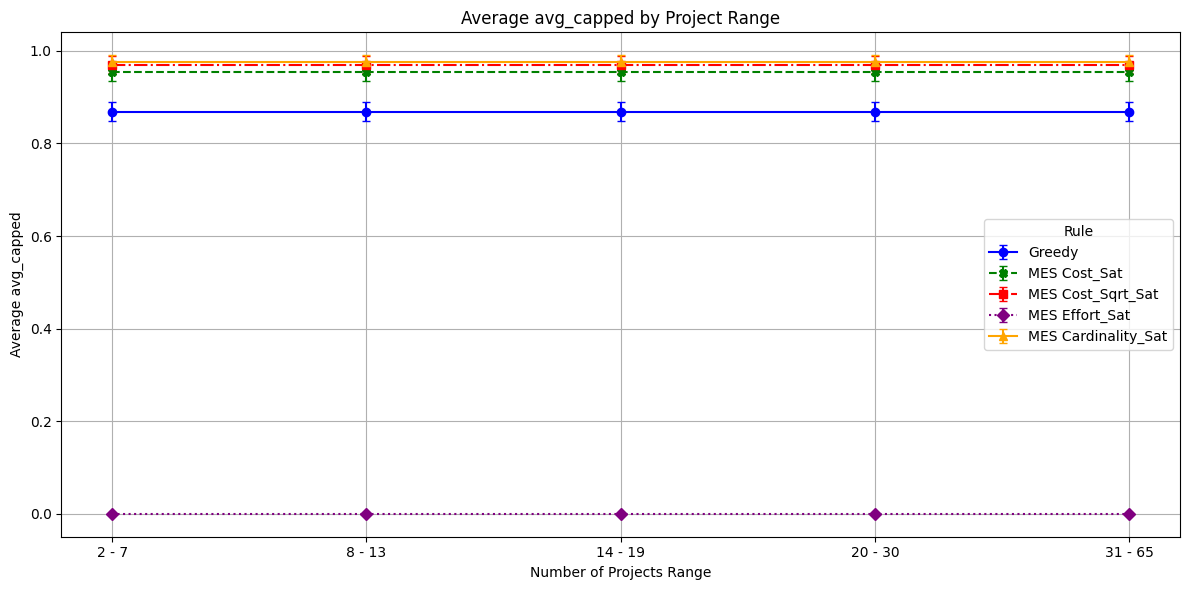

{'Greedy': {'x': ['2 - 7', '8 - 13', '14 - 19', '20 - 30', '31 - 65'], 'y': [17.190617773807233, 17.190617773807233, 17.190617773807233, 17.190617773807233, 17.190617773807233], 'yerr': [8.998254717500634, 8.998254717500634, 8.998254717500634, 8.998254717500634, 8.998254717500634]}, 'MES Cost_Sat': {'x': ['2 - 7', '8 - 13', '14 - 19', '20 - 30', '31 - 65'], 'y': [3.8617705332642682, 3.8617705332642682, 3.8617705332642682, 3.8617705332642682, 3.8617705332642682], 'yerr': [1.4807281615761774, 1.4807281615761774, 1.4807281615761774, 1.4807281615761774, 1.4807281615761774]}, 'MES Cost_Sqrt_Sat': {'x': ['2 - 7', '8 - 13', '14 - 19', '20 - 30', '31 - 65'], 'y': [1.8686496426407604, 1.8686496426407604, 1.8686496426407604, 1.8686496426407604, 1.8686496426407604], 'yerr': [1.3148295991517631, 1.3148295991517631, 1.3148295991517631, 1.3148295991517631, 1.3148295991517631]}, 'MES Effort_Sat': {'x': ['2 - 7', '8 - 13', '14 - 19', '20 - 30', '31 - 65'], 'y': [0, 0, 0, 0, 0], 'yerr': [0, 0, 0, 0, 0]

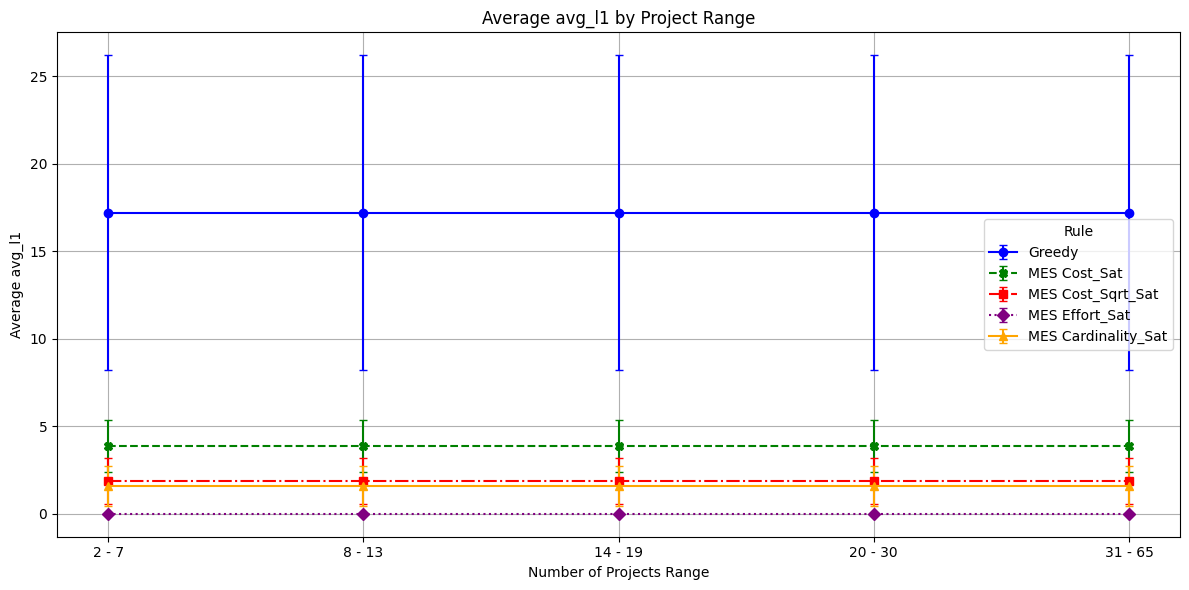

In [13]:
for name in ["avg_capped", "avg_l1"]:
        visualize_data(bins, outcomes, name)